# Solve 1D wave equation using convolution from pytorch

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import numpy as np
import torch
from torch import nn

## Solve the 1D acoustic wave equation

## $ \frac{\partial^2 u}{\partial t^2} = c^2 \frac{\partial^2 u}{\partial x^2}  $

For our purposes, we will use a dimensionless velocity $c=1$

The spatial gradient is calculated via convolution of the kernel

$\Delta x = \Delta t * u_{i-1} - 2u_i + u_{i+1}$

where $u_i$s are the spatial discretization of the displacement


In [2]:
laplace1d = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=(3), padding=1, bias=False)
laplace1d.weight = nn.Parameter(torch.tensor([[[1,-2,1]]], dtype=torch.float))

pad = nn.ReflectionPad1d(1)


In [3]:
laplace1d.weight

Parameter containing:
tensor([[[ 1., -2.,  1.]]], requires_grad=True)

## To calculate the Laplacian of a 1d vector, convolve the vector with the laplace1d layer

In [4]:
dx = 0.1
xmax = 10

x = torch.arange(0,xmax, dx).unsqueeze(0).unsqueeze(0)
u = 0.1 * torch.sin(x)
d2udx2 = 1/(dx**2) * laplace1d(u)

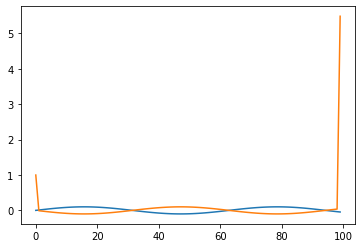

In [5]:
plt.plot(u.squeeze().numpy())
plt.plot(d2udx2.squeeze().detach().numpy())

In [6]:
x.shape, u.shape

(torch.Size([1, 1, 100]), torch.Size([1, 1, 100]))

## Back to wave eqn

Discretization of 1d wave equation

$u^{n+1}_i = -u^{n-1}_i + 2u^{n}_i + C^2(u^{n}_{i+1} - 2u^{n}_{i} + u^{n}_{i-1})$

where 

$C = c\frac{\Delta t}{\Delta x}$ 

and $c$ is the wave speed.

The quantity multiplied by $C$ is simply the Laplacian, therefore

$u^{n+1}_i = -u^{n-1}_i + 2u^{n}_i + C^2*laplacian1d(u)$

So to advance one timestep

In [7]:
def advance(u, u_old, C):
    return -u_old + 2*u + C**2 * laplace1d(u)

In [8]:
π = torch.tensor(np.pi)

dx = 0.05
xmax = 10
dt = 0.05

#assume wave speed of 1
C = (dt/dx)**2

x = torch.arange(0,xmax, dx).unsqueeze(0).unsqueeze(0)

# sinusoidal initial conditions
#u_init = torch.sin(2*π*x/(xmax-dx))

# triangular initial conditions
#u_init = 2/xmax*(xmax/2 - np.abs(xmax/2-x-dx))

# box wave initial conditions - doesnt work, too much numerical artifact
#u_init = torch.cat((torch.zeros(333), torch.ones(334), torch.zeros(333))).unsqueeze(0).unsqueeze(0)

# gaussian init condition
u_init = torch.exp(-(x - 5)**2/(2*1**2))

nsteps = 1000

In [9]:
# initial conditions - need 2 timesteps since the second time derivative depends on 2 iterations into past
u = [u_init]
u.append(u_init)
# boundary conditions set by having a padding of 0 at each end built into laplace1d

for step in range(nsteps):
    u_new = advance(u[-1], u[-2], C)
    u.append(u_new)

u = np.vstack([x.squeeze().detach().numpy() for x in u])

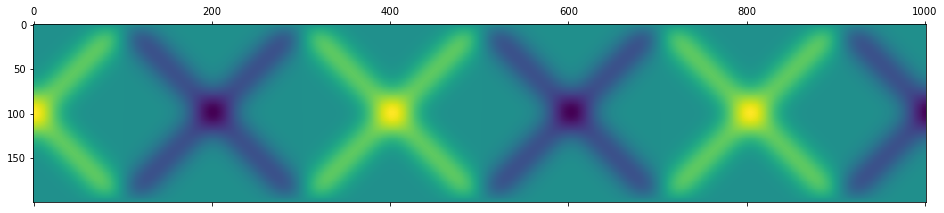

In [10]:
plt.matshow(u.T)

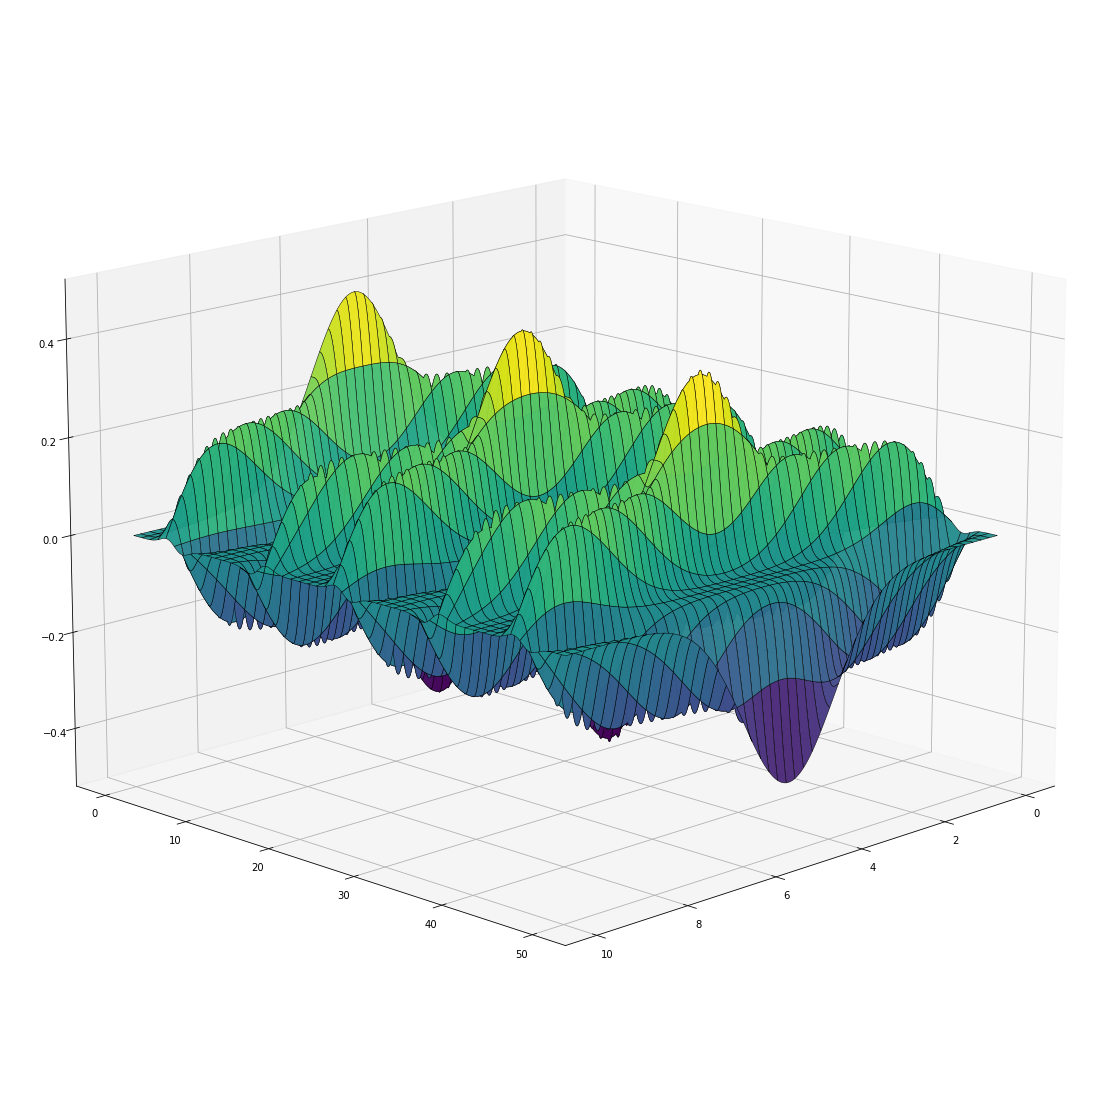

In [11]:
fig = plt.figure(figsize=(20,20))
ax = fig.gca(projection='3d')

x_ = np.arange(0,10,dx)
y_ = np.arange(0, nsteps*dt, dt)

xv, yv = np.meshgrid(x_,y_)
surf = ax.plot_surface(xv, yv, 0.4*u[:xv.shape[0],...], 
                       alpha=0.95, 
                       cmap='viridis', 
                       edgecolor='black',
                       linewidth=0.5)
ax.view_init(15,45)
ax.set_zlim((-0.5,0.5))
plt.show()

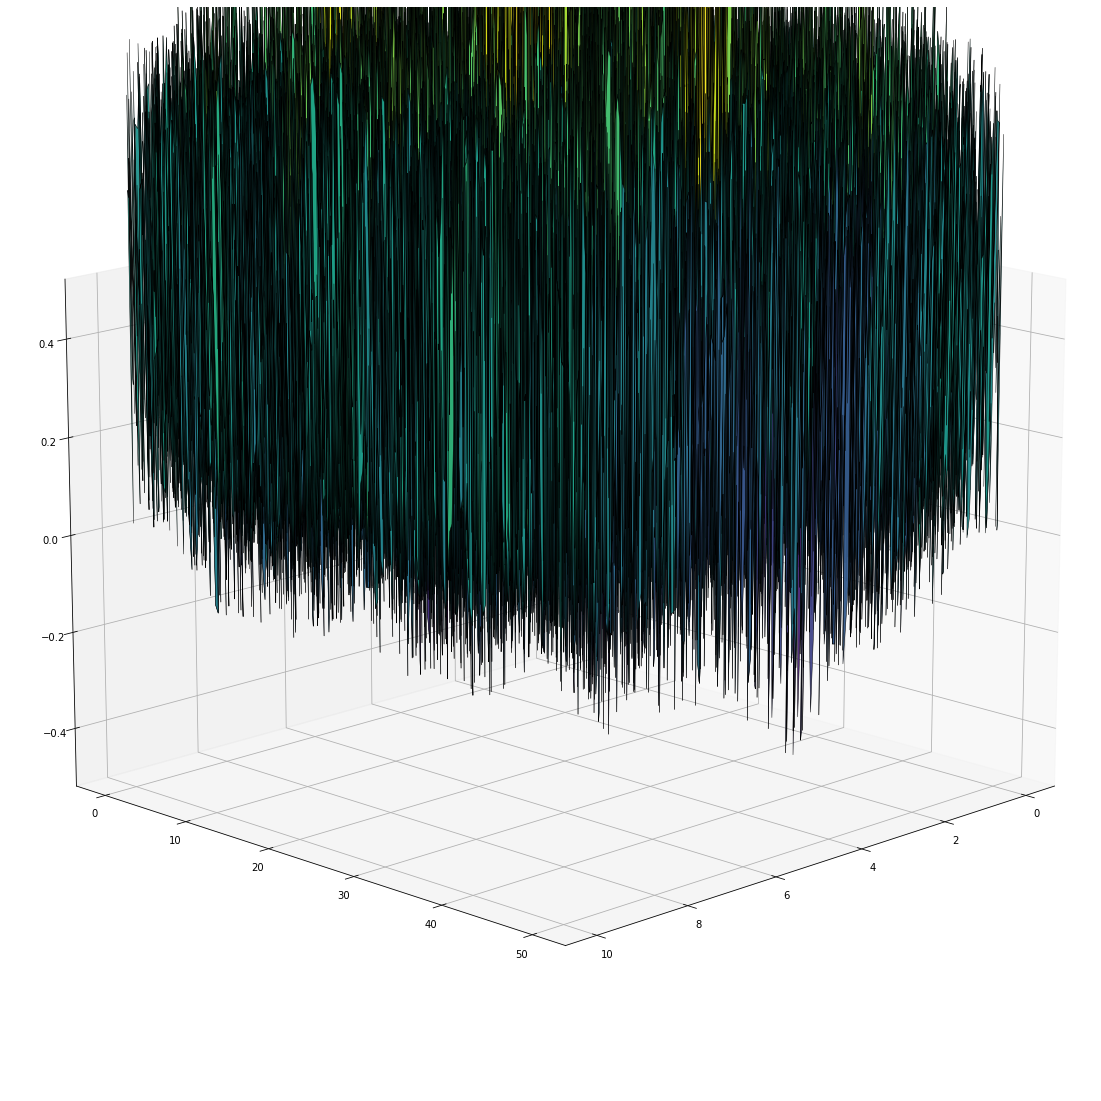

In [12]:
#Noisy

fig = plt.figure(figsize=(20,20))
ax = fig.gca(projection='3d')

x_ = np.arange(0,10,dx)
y_ = np.arange(0, nsteps*dt, dt)

xv, yv = np.meshgrid(x_,y_)
zv = 0.4*u[:xv.shape[0],...]
zv_verynoisy = 1 * np.random.rand(*zv.shape) + zv
surf = ax.plot_surface(xv, yv, zv_verynoisy, 
                       alpha=0.95, 
                       cmap='viridis', 
                       edgecolor='black',
                       linewidth=0.5)
ax.view_init(15,45)
ax.set_zlim((-0.5,0.5))
plt.show()

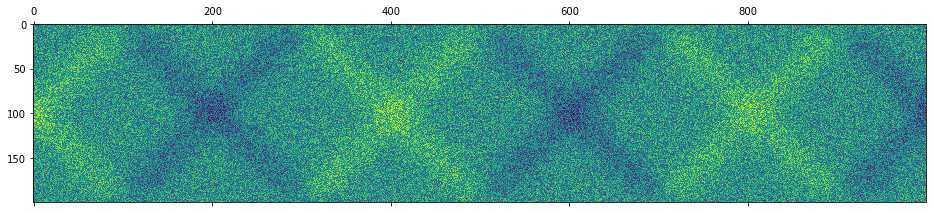

In [13]:
plt.matshow(zv_verynoisy.T)

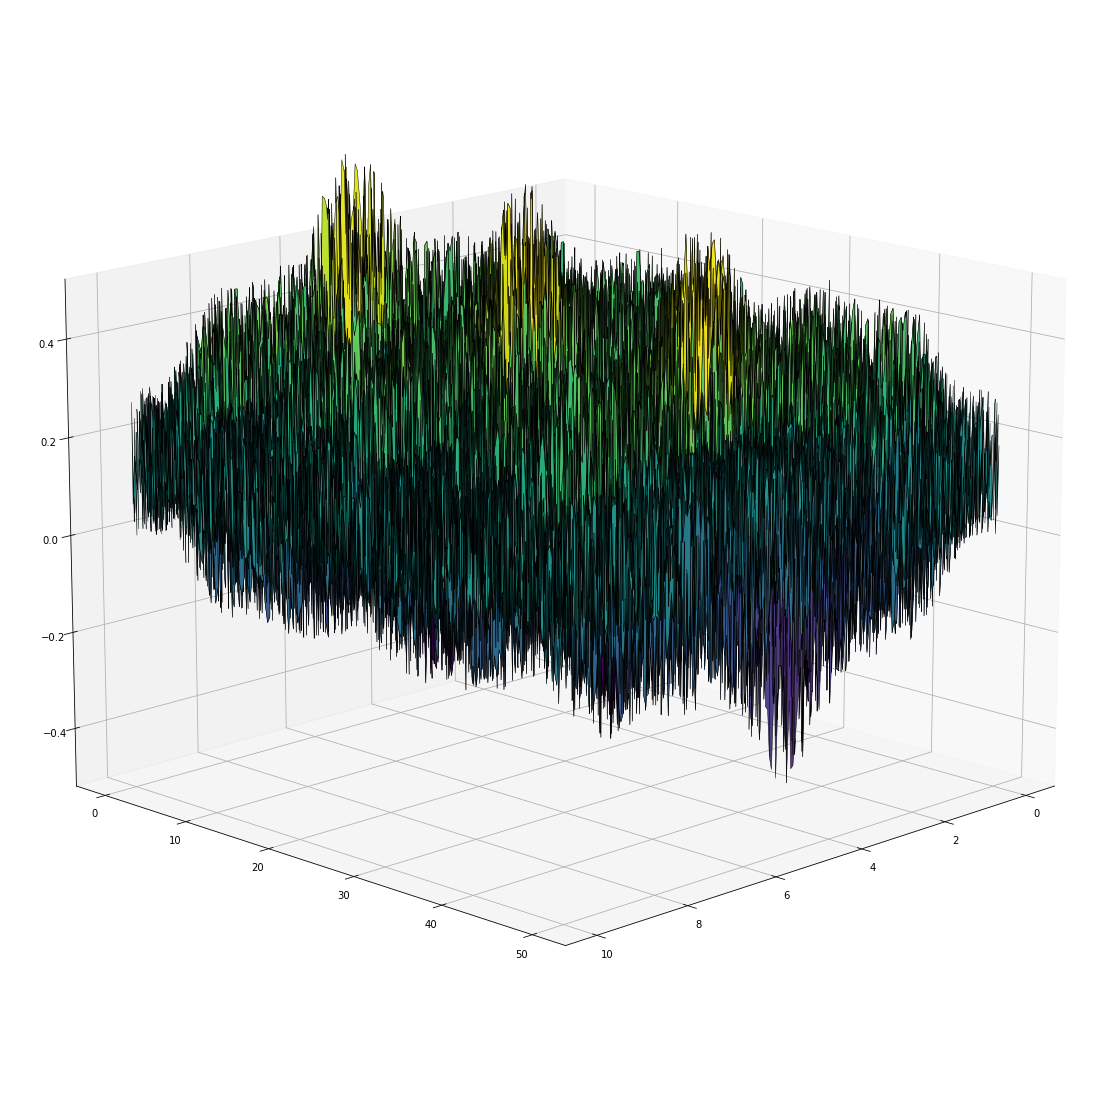

In [14]:
fig = plt.figure(figsize=(20,20))
ax = fig.gca(projection='3d')

x_ = np.arange(0,10,dx)
y_ = np.arange(0, nsteps*dt, dt)

xv, yv = np.meshgrid(x_,y_)
zv = 0.4*u[:xv.shape[0],...]
zv_noisy = 0.3 * np.random.rand(*zv.shape) + zv
surf = ax.plot_surface(xv, yv, zv_noisy, 
                       alpha=0.95, 
                       cmap='viridis', 
                       edgecolor='black',
                       linewidth=0.5)
ax.view_init(15,45)
ax.set_zlim((-0.5,0.5))
plt.show()

## So this method works.  Now we can use it to generate data for POD and SINDy analysis

In [15]:
# save from above
np.save('noisy_gaussianwave.npy', zv_noisy)
np.save('verynoisy_gaussianwave.npy', zv_verynoisy)
np.save('gaussianwave.npy', zv)

array([42.491535, 28.744686, 13.157059], dtype=float32)

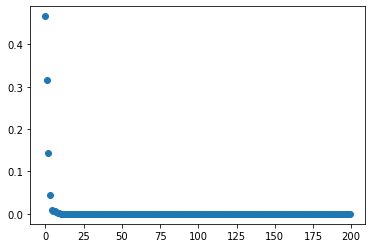

In [41]:
U,S,VT = np.linalg.svd(zv)
plt.plot(S/np.sum(S), 'o')
S[:3]

In [18]:
U.shape, S.shape, VT.shape

((1000, 1000), (200,), (200, 200))

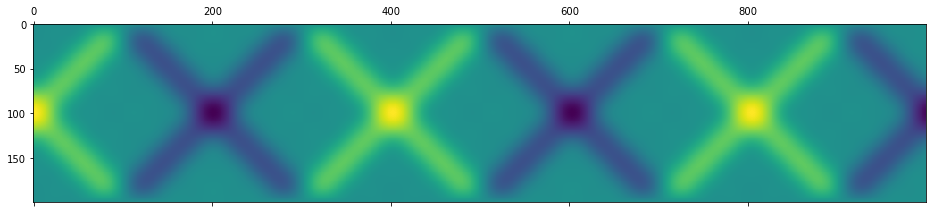

In [47]:
ncpt = 4
plt.matshow((U[:,:ncpt]@np.diag(S[:ncpt])@VT[:ncpt,:]).T)

array([42.491535  , 28.744686  , 13.157059  ,  4.074333  ,  0.85374045],
      dtype=float32)

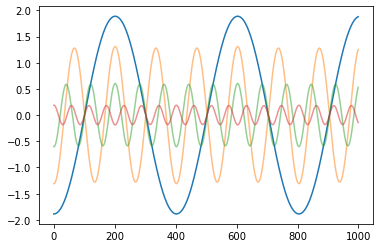

In [49]:
# First 3 basis vectors
plt.plot(U[...,0]*S[0])
plt.plot(U[...,1]*S[1], alpha=0.5)
plt.plot(U[...,2]*S[2], alpha=0.5)
plt.plot(U[...,3]*S[3], alpha=0.5)
S[:5]

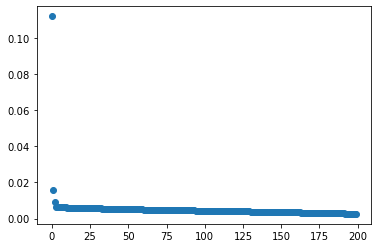

In [36]:
U,S,VT = np.linalg.svd(zv_verynoisy)
plt.plot(S/np.sum(S), 'o')

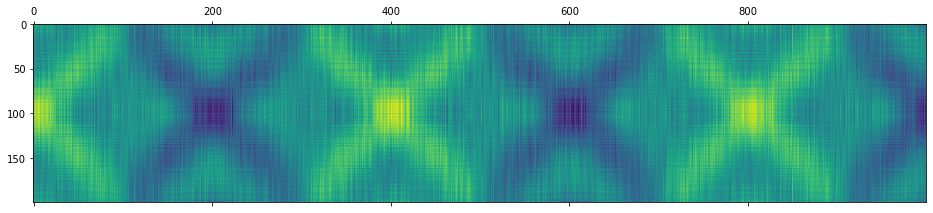

In [37]:
ncpt = 3
plt.matshow((U[:,:ncpt]@np.diag(S[:ncpt])@VT[:ncpt,:]).T)

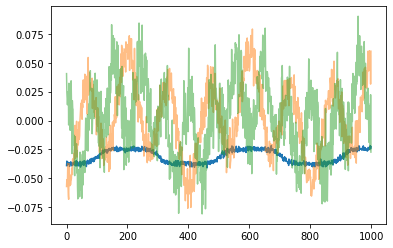

In [38]:
# First 3 basis vectors
plt.plot(U[...,0])
plt.plot(U[...,1], alpha=0.5)
plt.plot(U[...,2], alpha=0.5)

## Look at the SVD/POD on sinusoidal initial conditions

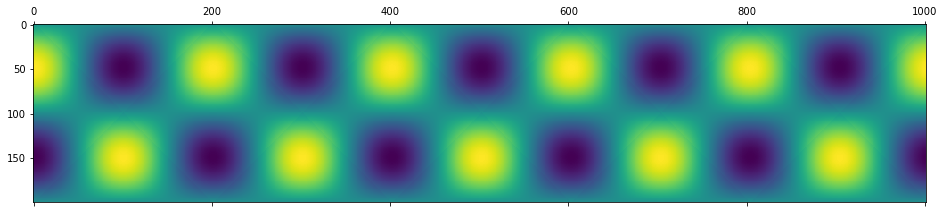

In [24]:
# sinusoidal initial conditions
u_init = torch.sin(2*π*x/(xmax-dx))

# initial conditions - need 2 timesteps since the second time derivative depends on 2 iterations into past
u = [u_init]
u.append(u_init)
# boundary conditions set by having a padding of 0 at each end built into laplace1d

for step in range(nsteps):
    u_new = advance(u[-1], u[-2], C)
    u.append(u_new)

u = np.vstack([x.squeeze().detach().numpy() for x in u])

plt.matshow(u.T)

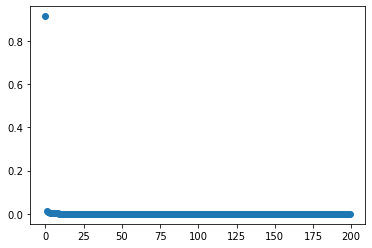

In [25]:
U,S,VT = np.linalg.svd(u)
plt.plot(S/np.sum(S), 'o')

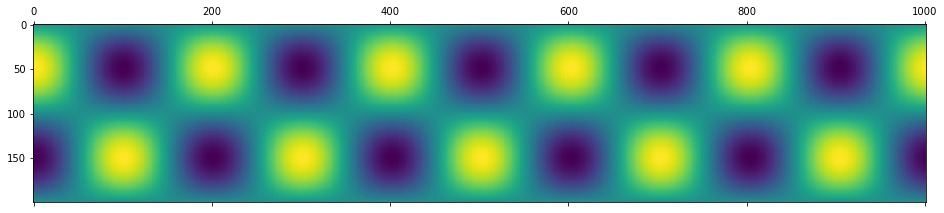

In [26]:
ncpt = 1
plt.matshow((U[:,:ncpt]@np.diag(S[:ncpt])@VT[:ncpt,:]).T)

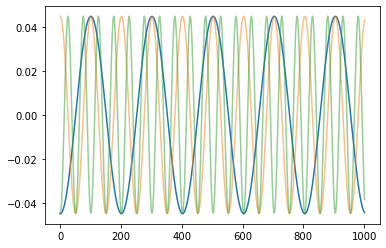

In [27]:
# First 3 basis vectors
plt.plot(U[...,0])
plt.plot(U[...,1], alpha=0.5)
plt.plot(U[...,3], alpha=0.5)

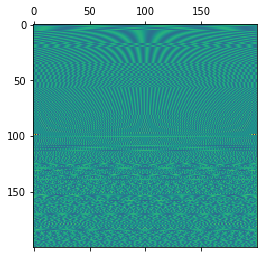

In [28]:
plt.matshow(VT)

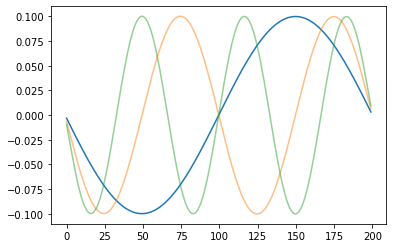

In [29]:
plt.plot(VT.T[...,0])
plt.plot(VT.T[...,1], alpha=0.5)
plt.plot(VT.T[...,2], alpha=0.5)

In [30]:
(U[:,:3]@np.diag(S[:3])).shape

(1002, 3)

In [31]:
np.save('sine.npy', u)